In [1]:
# Extract Data from DB
import pyodbc
import pandas as pd
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Fetch variables
DB_DRIVER = os.getenv("DB_DRIVER")
DB_SERVER = os.getenv("DB_SERVER")
DB_DATABASE = os.getenv("DB_DATABASE")
DB_USERNAME = os.getenv("DB_USERNAME")
DB_PASSWORD = os.getenv("DB_PASSWORD")

# Build connection string
connection_string = pyodbc.connect(
    f'Driver={{{DB_DRIVER}}};'
    f'Server={DB_SERVER};'
    f'Database={DB_DATABASE};'
    f'UID={DB_USERNAME};'
    f'PWD={DB_PASSWORD};'
    'Encrypt=yes;'
    'TrustServerCertificate=yes;'
)


query = pd.read_sql_query('''
    SELECT Sales_Total, Sales_Date
    FROM dbo.Daily_Sales
    WHERE g_resturant_code = 'MZJ' AND Sales_Total > 0
''', connection_string)

df = pd.DataFrame(query)
df.dropna()




/var/folders/0j/c2z29_pj61xb144lddvfx97m0000gn/T/ipykernel_5177/170805303.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  query = pd.read_sql_query('''


,Sales_Total,Sales_Date
0,1382.00,2024-04-26
1,554.70,2024-04-29
2,2418.30,2024-04-30
3,1619.25,2024-05-01
4,1811.65,2024-05-02
...,...,...
352,2958.00,2025-05-01
353,2674.00,2025-05-02
354,2722.00,2025-05-03
355,1861.00,2025-05-04


In [2]:
df.head()

,Sales_Total,Sales_Date
0,1382.00,2024-04-26
1,554.70,2024-04-29
2,2418.30,2024-04-30
3,1619.25,2024-05-01
4,1811.65,2024-05-02


In [3]:
df["day_of_week"] = df["Sales_Date"].dt.dayofweek

max = 0
min = 10
# Check the day of week range
for i in range(0, 100):
    x = df.iloc[i]["day_of_week"]
    if(x > max):
        max = x
    if (x < min):
        min = x
print(min, max)


0 6


In [4]:
df["is_weekend"] = df["day_of_week"].isin([4,5,6]).astype(int)  # Consider Friday, Saturday, Sunday as weekends
df.head()

,Sales_Total,Sales_Date,day_of_week,is_weekend
0,1382.00,2024-04-26,4,1
1,554.70,2024-04-29,0,0
2,2418.30,2024-04-30,1,0
3,1619.25,2024-05-01,2,0
4,1811.65,2024-05-02,3,0


In [5]:
# Further Statistical Features

df["lag_1"] = df["Sales_Total"].shift(1)
df["lag_7"] = df["Sales_Total"].shift(7)
df["lag_14"] = df["Sales_Total"].shift(14)

df["rolling_7"] = df["Sales_Total"].rolling(window=7).mean()
df["rolling_14"] = df["Sales_Total"].rolling(window=14).mean()

df["rolling_7_sales"]= df["Sales_Total"].rolling(window=7, min_periods=1).mean()



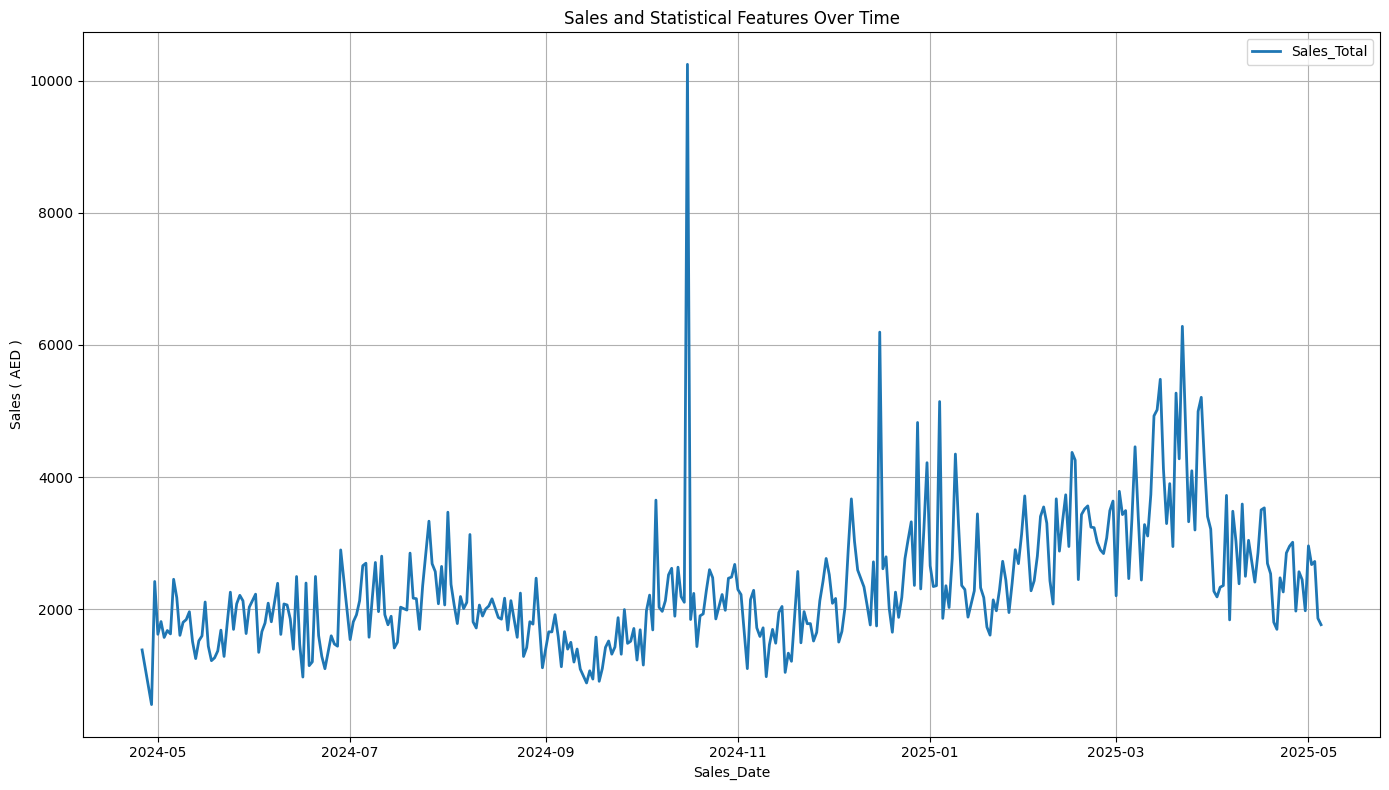

In [6]:
# Visualize the sales data per date
import matplotlib.pyplot as plt


# Plot
plt.figure(figsize=(14, 8))

# Original sales
plt.plot(df['Sales_Date'], df['Sales_Total'], label='Sales_Total', linewidth=2)

# Decorations
plt.xlabel('Sales_Date')
plt.ylabel('Sales ( AED )')
plt.title('Sales and Statistical Features Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

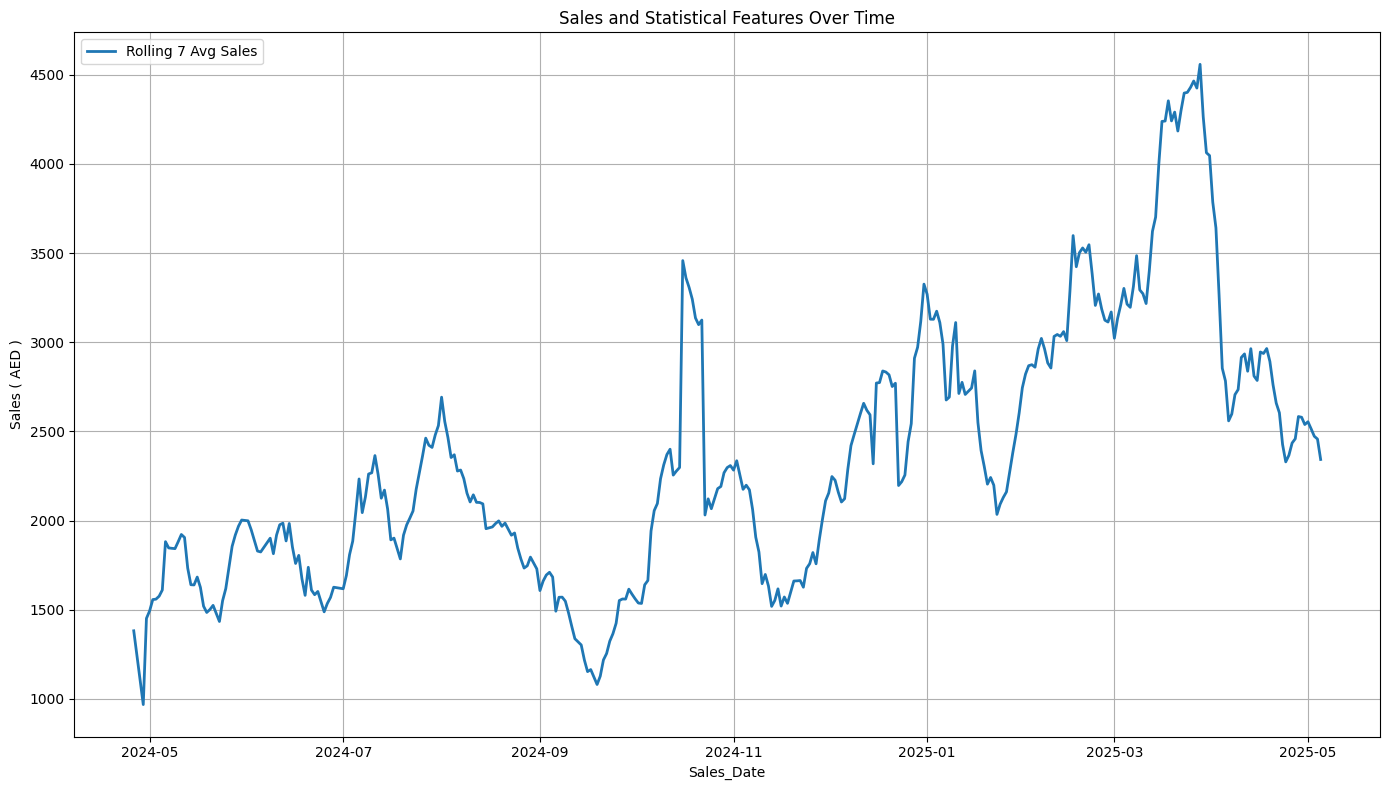

In [7]:
# Visualize the rolling 7-day average sales data per date
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(14, 8))

# Original sales
plt.plot(df['Sales_Date'], df['rolling_7_sales'], label='Rolling 7 Avg Sales', linewidth=2)

# Decorations
plt.xlabel('Sales_Date')
plt.ylabel('Sales ( AED )')
plt.title('Sales and Statistical Features Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
X = df[["day_of_week","lag_1", "lag_7", "lag_14", "rolling_7", "rolling_14"]]
y = df["Sales_Total"]  # change to rolling_7_sales

# Split df to a training and validation (The training is used to train and test while validation is the validation data)
df = df.sort_values('Sales_Date')

# Define how much of the data you want for validation
validation_size = 0.2  # for example, 20% validation

# Calculate split index
split_index = int(len(df) * (1 - validation_size))

# Split the data
train_df = df.iloc[:split_index]
val_df = df.iloc[split_index:]

X_val = val_df[["day_of_week","lag_1", "lag_7", "lag_14",  "rolling_7", "rolling_14"]]
y_val = val_df["Sales_Total"]

In [9]:
# Train model

from xgboost import XGBRegressor  
import lightgbm as lgb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
dates_train = df["Sales_Date"][:len(X_train)]
dates_test = df["Sales_Date"][len(X_train):]


model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    objective="reg:squarederror",  # Very important for regression!
    random_state=42
)

model.fit(X_train, y_train)

xgb_pred = model.predict(X_test)

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)
lgb_model.fit(X_train, y_train)

# Predict
lgb_pred = model.predict(X_test)

y_pred = (lgb_pred + xgb_pred) / 2

import numpy as np
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse/df["Sales_Total"].mean() * 100, '%')

mae = mean_absolute_error(y_test, y_pred)
print("MAE (Mean Absolute Error):", mae)
print("Percentage MAE/Mean (Normalized Error):", mae/df["Sales_Total"].mean() * 100, '%')

medae = median_absolute_error(y_test, y_pred)
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE/Mean (Normalized Error):", medae/df["Sales_Total"].mean() * 100, '%')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 476
[LightGBM] [Info] Number of data points in the train set: 285, number of used features: 6
[LightGBM] [Info] Start training from score 2153.105368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

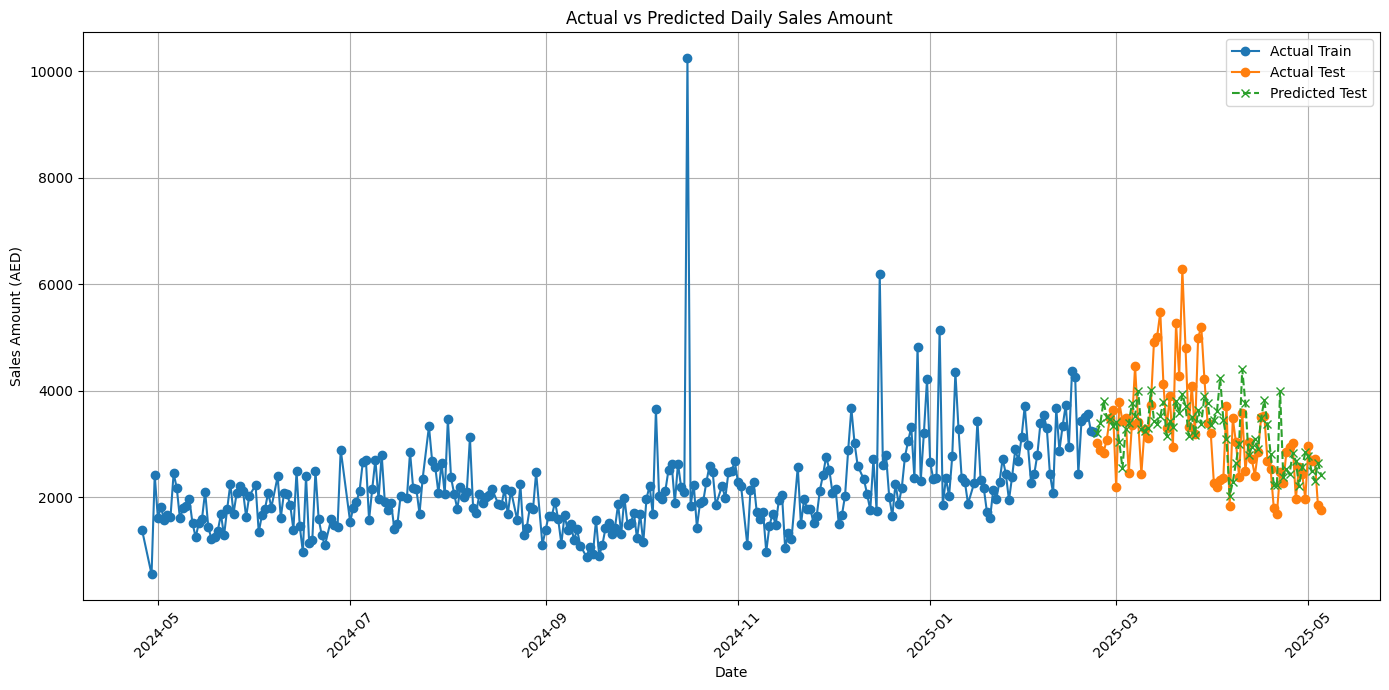

In [10]:
# Plot
plt.figure(figsize=(14, 7))

# Plot actual sales (whole timeline)
plt.plot(dates_train, y_train, label="Actual Train", marker='o')
plt.plot(dates_test, y_test, label="Actual Test", marker='o')

# Plot predicted sales (only for test set)
plt.plot(dates_test, y_pred, label="Predicted Test", marker='x', linestyle="--")

plt.title("Actual vs Predicted Daily Sales Amount ")
plt.xlabel("Date")
plt.ylabel("Sales Amount (AED)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
# Save Model
import joblib

joblib.dump(model, "models/xgb_model.pkl")
joblib.dump(lgb_model, "models/lgb_model.pkl")

['models/lgb_model.pkl']

In [12]:
# Load models
xgb_loaded = joblib.load("models/xgb_model.pkl")
lgb_loaded = joblib.load("models/lgb_model.pkl")

# Predict again using loaded models
xgb_pred_loaded = xgb_loaded.predict(X_val)
lgb_pred_loaded = lgb_loaded.predict(X_val)

# Combine predictions
y_pred_loaded = (xgb_pred_loaded + lgb_pred_loaded) / 2

# Evaluate
rmse_loaded = np.sqrt(mean_squared_error(y_val, y_pred_loaded))
print("RMSE after loading models:", rmse_loaded)
print("Percentage RMSE/Mean (Normalized Error):", rmse_loaded / df["Sales_Total"].mean() * 100, '%')

mae_loaded = mean_absolute_error(y_val, y_pred_loaded)
print("MAE after loading models:", mae_loaded)
print("Percentage MAE/Mean (Normalized Error):", mae_loaded / df["Sales_Total"].mean() * 100, '%')

medae_loaded = median_absolute_error(y_val, y_pred_loaded)
print("MedAE after loading models:", medae_loaded)
print("Percentage MedAE/Mean (Normalized Error):", medae_loaded / df["Sales_Total"].mean() * 100, '%')

RMSE after loading models: 851.0284957270086
Percentage RMSE/Mean (Normalized Error): 35.9673781030859 %
MAE after loading models: 659.2911211908557
Percentage MAE/Mean (Normalized Error): 27.86390015721112 %
MedAE after loading models: 549.1365927176266
Percentage MedAE/Mean (Normalized Error): 23.20839262102788 %


In [13]:
print(len(val_df), len(y_pred_loaded))

72 72


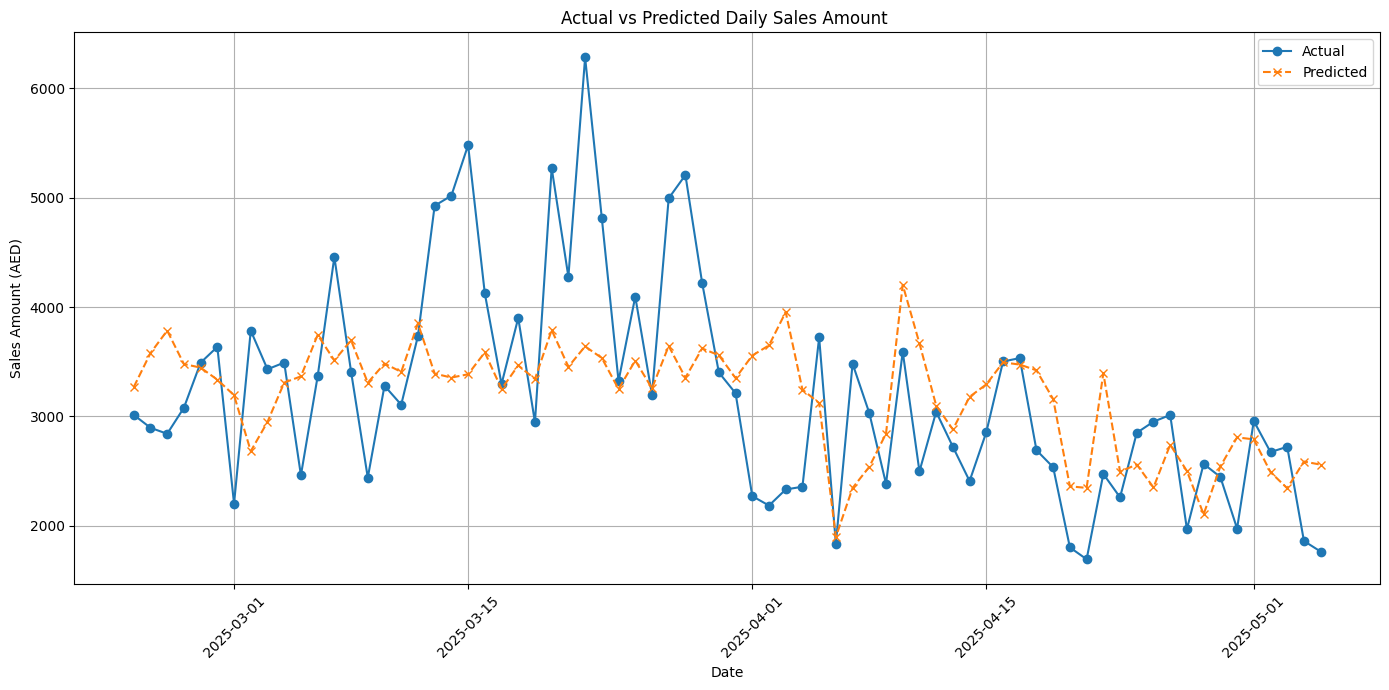

In [14]:
# Plot validation Result

# Plot
plt.figure(figsize=(14, 7))

# Plot actual sales (whole timeline)
plt.plot(val_df["Sales_Date"], y_val, label="Actual", marker='o')

# Plot predicted sales (only for test set)
plt.plot(val_df["Sales_Date"], y_pred_loaded, label="Predicted", marker='x', linestyle="--")

plt.title("Actual vs Predicted Daily Sales Amount ")
plt.xlabel("Date")
plt.ylabel("Sales Amount (AED)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# The model is not great by any stretch, that is due to the lack of features and comprehensible data. However, it performs better than naive methods
# of predictions such as same day last week/last month, which is a significant improvement in our case.